In [1]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import json
import torchvision.transforms.functional as F
from matplotlib import cm as CM
from image import *
from model import CSRNet
import torch
%matplotlib inline

/tmp/ipykernel_73936/1028975186.py:8: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter
/home/aidin/anaconda3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/aidin/anaconda3/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
from torchvision import datasets, transforms
transform=transforms.Compose([
                       transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
                   ])

In [4]:
root = 'Shanghai/'

In [5]:
#now generate the ShanghaiA's ground truth
part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')
path_sets = [part_A_test]

In [6]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [8]:
model = CSRNet()

/home/aidin/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aidin/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
model = model.cpu()

In [10]:
best_model = 'PartAmodel_best.pth.tar'

checkpoint = torch.load(
    os.path.join(
        'trained_models',
        best_model
    ),
    map_location=torch.device('cpu')
)


In [11]:
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [14]:
mae = 0
total_images = len(img_paths)

for i, img_path in enumerate(img_paths):
    img = 255.0 * F.to_tensor(Image.open(img_path).convert('RGB'))
    img[0, :, :] -= 92.8207477031
    img[1, :, :] -= 95.2757037428
    img[2, :, :] -= 104.877445883
    #img = img.cpu()
    img = transform(Image.open(img_paths[i]).convert('RGB')).cpu()

    gt_file = h5py.File(img_path.replace('.jpg', '.h5').replace('images', 'ground_truth'), 'r')
    groundtruth = np.asarray(gt_file['density'])

    output = model(img.unsqueeze(0))

    absolute_difference = np.abs(output.detach().cpu().sum().numpy() - np.sum(groundtruth))
    mae += absolute_difference

    print(f"Processed image {i + 1}/{total_images} - MAE: {absolute_difference}")

average_mae = mae / total_images
print(f"\nAverage MAE: {average_mae}")


Processed image 1/182 - MAE: 0.7630615234375
Processed image 2/182 - MAE: 43.502655029296875
Processed image 3/182 - MAE: 33.142578125
Processed image 4/182 - MAE: 2.402862548828125
Processed image 5/182 - MAE: 119.41146850585938
Processed image 6/182 - MAE: 0.80029296875
Processed image 7/182 - MAE: 1.90814208984375
Processed image 8/182 - MAE: 20.998809814453125
Processed image 9/182 - MAE: 92.01412963867188
Processed image 10/182 - MAE: 170.57781982421875
Processed image 11/182 - MAE: 32.174468994140625
Processed image 12/182 - MAE: 0.37542724609375
Processed image 13/182 - MAE: 15.042755126953125
Processed image 14/182 - MAE: 67.5811767578125
Processed image 15/182 - MAE: 112.30101013183594
Processed image 16/182 - MAE: 160.073486328125
Processed image 17/182 - MAE: 231.455322265625
Processed image 18/182 - MAE: 65.04296875
Processed image 19/182 - MAE: 8.885894775390625
Processed image 20/182 - MAE: 8.170059204101562
Processed image 21/182 - MAE: 32.68956756591797
Processed image 

In [15]:
output = model(img.unsqueeze(0))

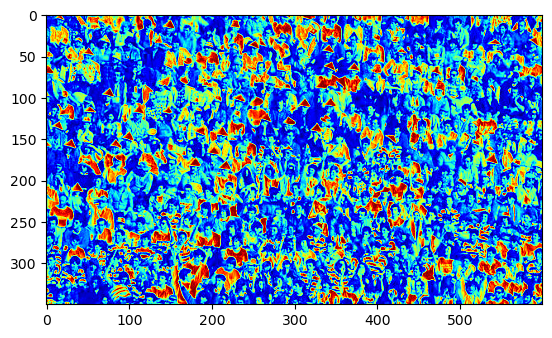

In [16]:
plt.imshow(img[2].detach().cpu().numpy(), cmap=CM.jet)

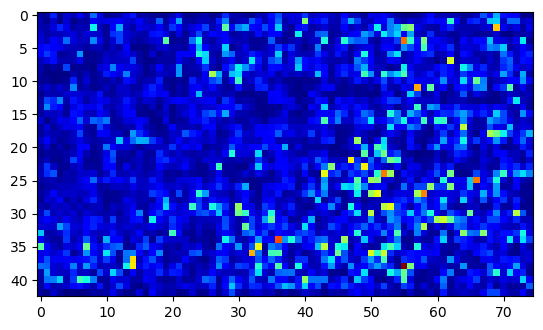

In [17]:
plt.imshow(output.detach().cpu().squeeze().numpy(), cmap=CM.jet)

In [18]:
output.detach().cpu().squeeze().numpy().sum()

455.62616

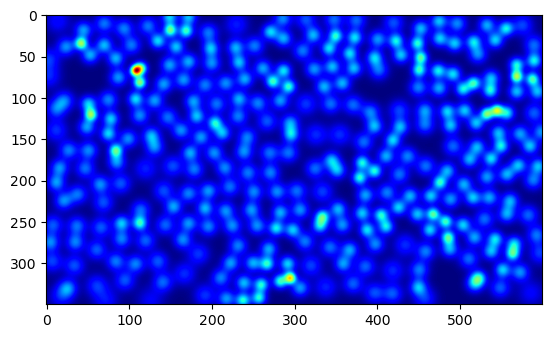

In [21]:
gt_file = h5py.File(img_paths[-1].replace('.jpg','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [23]:
groundtruth.sum()

308.17908

In [25]:
best_model = 'partBmodel_best.pth.tar'

checkpoint = torch.load(
    os.path.join(
        'trained_models',
        best_model
    ),
    map_location=torch.device('cpu')
)


In [26]:
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [27]:
path_sets = [part_B_test]
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [28]:
mae = 0
total_images = len(img_paths)

for i, img_path in enumerate(img_paths):
    img = 255.0 * F.to_tensor(Image.open(img_path).convert('RGB'))
    img[0, :, :] -= 92.8207477031
    img[1, :, :] -= 95.2757037428
    img[2, :, :] -= 104.877445883
    #img = img.cpu()
    img = transform(Image.open(img_paths[i]).convert('RGB')).cpu()

    gt_file = h5py.File(img_path.replace('.jpg', '.h5').replace('images', 'ground_truth'), 'r')
    groundtruth = np.asarray(gt_file['density'])

    output = model(img.unsqueeze(0))

    absolute_difference = np.abs(output.detach().cpu().sum().numpy() - np.sum(groundtruth))
    mae += absolute_difference

    print(f"Processed image {i + 1}/{total_images} - MAE: {absolute_difference}")

average_mae = mae / total_images
print(f"\nAverage MAE: {average_mae}")


Processed image 1/316 - MAE: 9.593048095703146
Processed image 2/316 - MAE: 22.45208740234372
Processed image 3/316 - MAE: 7.392517089843736
Processed image 4/316 - MAE: 0.6787109375000853
Processed image 5/316 - MAE: 0.06997489929198508
Processed image 6/316 - MAE: 2.7816123962402415
Processed image 7/316 - MAE: 8.78494262695311
Processed image 8/316 - MAE: 15.771286010742074
Processed image 9/316 - MAE: 3.772977828979503
Processed image 10/316 - MAE: 3.4892501831054545
Processed image 11/316 - MAE: 0.6708755493164205
Processed image 12/316 - MAE: 8.310043334960938
Processed image 13/316 - MAE: 0.6640625000000142
Processed image 14/316 - MAE: 8.238166809082024
Processed image 15/316 - MAE: 41.11416625976551
Processed image 16/316 - MAE: 3.167129516601541
Processed image 17/316 - MAE: 18.874229431152358
Processed image 18/316 - MAE: 3.6790771484375
Processed image 19/316 - MAE: 19.19082641601551
Processed image 20/316 - MAE: 1.691864013671875
Processed image 21/316 - MAE: 27.5586242675

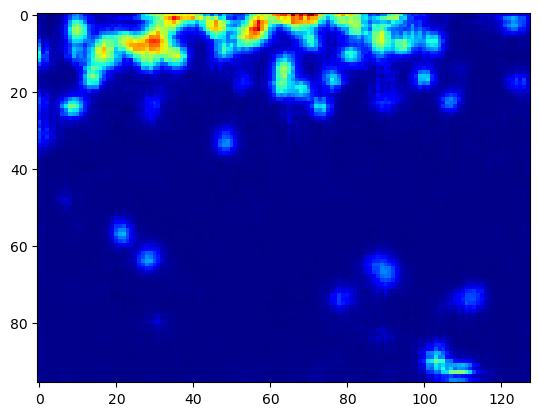

In [29]:
plt.imshow(output.detach().cpu().squeeze().numpy(), cmap=CM.jet)

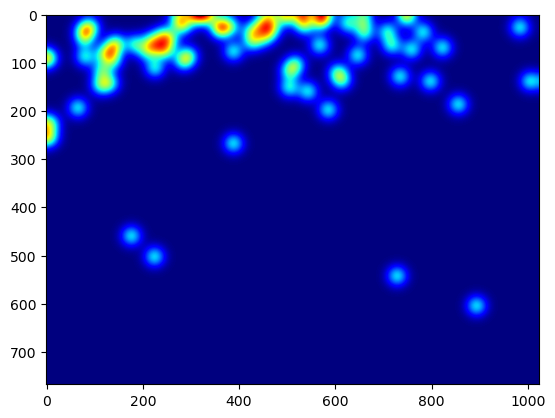

In [30]:
gt_file = h5py.File(img_paths[-1].replace('.jpg','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [31]:
groundtruth.sum()

71.99999999999994

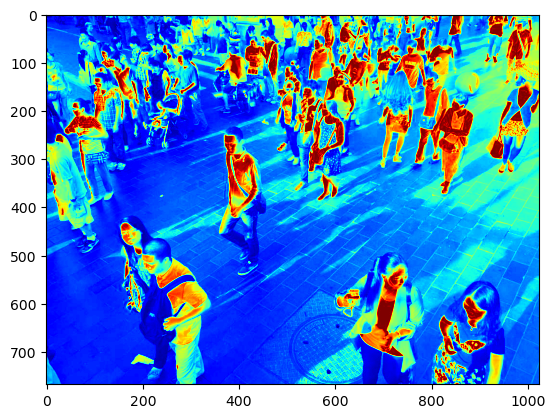

In [34]:
plt.imshow(img[0],cmap=CM.jet)